In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from lmfit import Minimizer, Parameters
import seaborn as sns
from rich.progress import track

sns.set(color_codes=True, style="white")

## Load Data

In [15]:
folder = "/Volumes/lsa-nwalter/Guoming_Gao_turbo/Walterlab_server/PROCESSED_DATA/RNA-in-HOPS_condensates/paper_figure_plots/Effect_traslation_FLmRNA"
os.chdir(folder)

lst_color = [
    "#C51E3A",  # FL, 2x
    "#9E0620",  # FL, 2x, puro
    "#ED022A",  # FL, 2x, Har
    "#B33E52",  # FL, 2x, CHX
    "#7A2130",  # FL, 2x, 4EGI1
]
lst_title = [
    "FL mRNA, -",
    "FL mRNA, +puromycin",
    "FL mRNA, +harringtonine",
    "FL mRNA, +cycloheximide",
    "FL mRNA, +4EGI1",
]
lst_fname_save = [
    "FL_2x",
    "FL_puro_2x",
    "FL_Har_2x",
    "FL_CHX_2x",
    "FL_4EGI1_2x",
]

In [2]:
lst_df = []
for f in track(lst_fname_save):
    lst_df.append(pd.read_csv("colocalization_AIO_concat-" + f + "_100ms.csv"))

Output()

## Functions

In [3]:
def get_dwell_times(array_in_condensate, array_trackID):
    # Find the indices where the array changes from False to True or vice versa
    change_indices_condensate = (
        np.where(array_in_condensate[:-1] != array_in_condensate[1:])[0] + 1
    )

    # Find the indices where the trackID changes
    change_indices_trackID = np.where(array_trackID[:-1] != array_trackID[1:])[0] + 1

    # Combine the change indices from both arrays
    change_indices = np.unique(
        np.concatenate((change_indices_condensate, change_indices_trackID))
    )

    # Add the start and end indices to the change_indices array
    change_indices = np.concatenate(([0], change_indices, [len(array_in_condensate)]))

    # Calculate the durations of each True event
    dwell_times = []
    for i in range(len(change_indices) - 1):
        if array_in_condensate[change_indices[i]]:
            dwell_times.append(change_indices[i + 1] - change_indices[i])

    return np.array(dwell_times)


# def get_dwell_times_split(array_in_condensate, array_trackID, array_R_nm):
#     threshold_PB_HOPS = 350  # nm
#     # Find the indices where the array changes from False to True or vice versa
#     change_indices_condensate = (
#         np.where(array_in_condensate[:-1] != array_in_condensate[1:])[0] + 1
#     )

#     # Find the indices where the trackID changes
#     change_indices_trackID = np.where(array_trackID[:-1] != array_trackID[1:])[0] + 1

#     # Combine the change indices from both arrays
#     change_indices = np.unique(
#         np.concatenate((change_indices_condensate, change_indices_trackID))
#     )

#     # Add the start and end indices to the change_indices array
#     change_indices = np.concatenate(([0], change_indices, [len(array_in_condensate)]))

#     # Calculate the durations of each True event
#     dwell_times_PB = []
#     dwell_times_HOPS = []
#     for i in range(len(change_indices) - 1):
#         if array_in_condensate[change_indices[i]]:
#             average_r = np.mean(array_R_nm[change_indices[i] : change_indices[i + 1]])
#             if average_r >= threshold_PB_HOPS:
#                 dwell_times_PB.append(change_indices[i + 1] - change_indices[i])
#             else:
#                 dwell_times_HOPS.append(change_indices[i + 1] - change_indices[i])

#     return np.array(dwell_times_PB), np.array(dwell_times_HOPS)


def calc_R2(ydata, yfit):
    # residual sum of squares (ss_tot)
    residuals = ydata - yfit
    ss_res = np.sum(residuals**2)
    # total sum of squares (ss_tot)
    ss_tot = np.sum((ydata - np.mean(ydata)) ** 2)
    # r_squared-value
    r_squared = 1 - (ss_res / ss_tot)

    return r_squared


def cdf_lmfit_dual(params, t, data):
    # define objective function: returns the array to be minimized
    """Model a decaying sine wave and subtract data."""
    a1 = params["a1"]
    a2 = params["a2"]
    tau1 = params["tau1"]
    tau2 = params["tau2"]
    model = 1 - a1 * np.exp(-t / tau1) - a2 * np.exp(-t / tau2)
    return model - data


def cdf_lmfit_single(params, t, data):
    # define objective function: returns the array to be minimized
    """Model a decaying sine wave and subtract data."""
    # a1 = params["a1"]
    tau1 = params["tau1"]
    model = 1 - np.exp(-t / tau1)
    return model - data


def fit_CDF_dual(dwell_times):
    bins = 100
    binrange = (0.1, 3)
    hist, bin_edges = np.histogram(dwell_times, bins=bins, range=binrange, density=True)
    cumulative_hist = np.cumsum(hist) / np.sum(hist)  # Convert the histogram to CDF
    bin_centers = bin_edges[:-1] + binrange[-1] / bins
    # bin_centers = bin_edges[:-1]

    # create a set of Parameters
    params = Parameters()
    params.add("a1", min=0, max=1, value=0)
    params.add("a2", expr="1-a1")
    params.add("tau1", min=0.03, max=0.5, value=0.1)  # min=ln2/0.1
    params.add("tau2", min=0.5, max=2, value=1)

    # do fit, with the default leastsq algorithm
    minner = Minimizer(cdf_lmfit_dual, params, fcn_args=(bin_centers, cumulative_hist))
    result = minner.minimize()

    a1 = result.params["a1"].value
    a2 = result.params["a2"].value
    tau1 = result.params["tau1"].value
    tau2 = result.params["tau2"].value
    a1_se = result.params["a1"].stderr
    a2_se = result.params["a2"].stderr
    tau1_se = result.params["tau1"].stderr
    tau2_se = result.params["tau2"].stderr

    xdata = bin_centers
    ydata = cumulative_hist
    yfit = cumulative_hist + result.residual
    R2 = calc_R2(ydata, yfit)

    # report_fit(result)
    print("a1", a1, a1_se)
    print("tau1", tau1, tau1_se)
    print("a2", a2, a2_se)
    print("tau2", tau2, tau2_se)
    print("R2", R2)

    return {
        "a1": a1,
        "a2": a2,
        "tau1": tau1,
        "tau2": tau2,
        "a1_se": a1_se,
        "a2_se": a2_se,
        "tau1_se": tau1_se,
        "tau2_se": tau2_se,
        "xdata": xdata,
        "ydata": ydata,
        "bin_centers": bin_centers,
        "yfit": yfit,
        "R2": R2,
    }


def fit_CDF_single(dwell_times):
    bins = 100
    binrange = (0.1, 3)
    hist, bin_edges = np.histogram(dwell_times, bins=bins, range=binrange, density=True)
    cumulative_hist = np.cumsum(hist) / np.sum(hist)  # Convert the histogram to CDF
    bin_centers = bin_edges[:-1] + binrange[-1] / bins
    # bin_centers = bin_edges[:-1]

    # create a set of Parameters
    params = Parameters()
    # params.add("a1", min=0, max=1, value=0.8)
    params.add("tau1", min=0.03, max=2, value=1)  # min=ln2/0.1

    # do fit, with the default leastsq algorithm
    minner = Minimizer(
        cdf_lmfit_single, params, fcn_args=(bin_centers, cumulative_hist)
    )
    result = minner.minimize()

    # a1 = result.params["a1"].value
    tau1 = result.params["tau1"].value
    # a1_se = result.params["a1"].stderr
    tau1_se = result.params["tau1"].stderr

    xdata = bin_centers
    ydata = cumulative_hist
    yfit = cumulative_hist + result.residual
    R2 = calc_R2(ydata, yfit)

    # report_fit(result)
    # print("a1", a1, a1_se)
    print("tau", tau1, tau1_se)
    print("R2", R2)

    return {
        # "a1": a1,
        "tau": tau1,
        # "a1_se": a1_se,
        "tau_se": tau1_se,
        "xdata": xdata,
        "ydata": ydata,
        "bin_centers": bin_centers,
        "yfit": yfit,
        "R2": R2,
    }


def count_dwell_events(array_in_condensate, array_trackID):
    # Find the indices where the array changes from False to True or vice versa
    change_indices_condensate = (
        np.where(array_in_condensate[:-1] != array_in_condensate[1:])[0] + 1
    )
    # Find the indices where the trackID changes
    change_indices_trackID = np.where(array_trackID[:-1] != array_trackID[1:])[0] + 1
    # Combine the change indices from both arrays
    change_indices = np.unique(
        np.concatenate((change_indices_condensate, change_indices_trackID))
    )
    # Add the start and end indices to the change_indices array
    change_indices = np.concatenate(([0], change_indices, [len(array_in_condensate)]))
    # Calculate the durations of each trajectory, and then all dwell events within
    N_dwell_per_track = []
    for i in range(len(change_indices_trackID) - 1):
        bool_change_indices_condensate_within_track = (
            change_indices_condensate >= change_indices_trackID[i]
        ) & (change_indices_condensate <= change_indices_trackID[i + 1])
        N_dwell_per_track.append(np.sum(bool_change_indices_condensate_within_track))

    return np.array(N_dwell_per_track)


# def count_dwell_events_split(array_in_condensate, array_trackID, array_R_nm):
#     threshold_PB_HOPS = 350  # nm
#     # Find the indices where the array changes from False to True or vice versa
#     change_indices_condensate = (
#         np.where(array_in_condensate[:-1] != array_in_condensate[1:])[0] + 1
#     )
#     # Find the indices where the trackID changes
#     change_indices_trackID = np.where(array_trackID[:-1] != array_trackID[1:])[0] + 1
#     # Combine the change indices from both arrays
#     change_indices = np.unique(
#         np.concatenate((change_indices_condensate, change_indices_trackID))
#     )
#     # Add the start and end indices to the change_indices array
#     change_indices = np.concatenate(([0], change_indices, [len(array_in_condensate)]))
#     # Calculate the durations of each trajectory, and then all dwell events within
#     N_dwell_per_track_PB = []
#     N_dwell_per_track_HOPS = []
#     for i in range(len(change_indices_trackID) - 1):
#         average_r = np.mean(
#             array_R_nm[change_indices_trackID[i] : change_indices_trackID[i + 1]]
#         )
#         bool_change_indices_condensate_within_track = (
#             change_indices_condensate >= change_indices_trackID[i]
#         ) & (change_indices_condensate <= change_indices_trackID[i + 1])
#         N_dwell_per_track = np.sum(bool_change_indices_condensate_within_track)

#         if average_r >= threshold_PB_HOPS:
#             N_dwell_per_track_PB.append(N_dwell_per_track)
#         else:
#             N_dwell_per_track_HOPS.append(N_dwell_per_track)

#     return (
#         np.array(N_dwell_per_track_PB),
#         np.array(N_dwell_per_track_HOPS),
#     )

## Interaction (Dwell) Time Calculate

In [4]:
lst_dwell_times = [
    get_dwell_times(df["InCondensate"].to_numpy(), df["RNA_trackID"].to_numpy()) * 0.1
    for df in lst_df
]
lst_results_single = [fit_CDF_single(dwell_times) for dwell_times in lst_dwell_times]
lst_results_dual = [fit_CDF_dual(dwell_times) for dwell_times in lst_dwell_times]

tau 0.24778079706085923 0.005828673624179455
R2 0.894669451017305
tau 0.2763831075676296 0.00680448440987961
R2 0.8857985243413132
tau 0.2694725242746283 0.006308017571000444
R2 0.8976861158707854
tau 0.2682268574926945 0.006664151461249085
R2 0.8820051675968494
tau 0.2617364027458368 0.006153343222798743
R2 0.8967031284214895
a1 0.7312617621530586 0.021681485780231335
tau1 0.14383458267247243 0.0061806794457305
a2 0.2687382378469414 0.021681485826740773
tau2 0.6904613639131003 0.04547124906577888
R2 0.985208186307432
a1 0.6658717477085216 0.025668896144075023
tau1 0.13969077283604103 0.007288286232990109
a2 0.33412825229147836 0.025668896110520593
tau2 0.6923811430619744 0.03774594982183236
R2 0.9878736684511195
a1 0.6775265506346968 0.023600594852533484
tau1 0.14273092147027402 0.007069627980159227
a2 0.3224734493653032 0.02360059490810758
tau2 0.6737170690547829 0.03500075969107878
R2 0.9876411820037367
a1 0.6639143334236569 0.03952915221681441
tau1 0.13368168796292074 0.00833967739

## Fit to CDF, 1x, 2x, individually, no split

In [16]:
for dwell_times, results_single, results_dual, color, title, fname_save in zip(
    lst_dwell_times,
    lst_results_single,
    lst_results_dual,
    lst_color,
    lst_title,
    lst_fname_save,
):
    plt.figure(figsize=(4, 3))
    ax = sns.histplot(
        data=dwell_times,
        color="gray",
        bins=100,
        binrange=(0.1, 3),
        stat="probability",
        common_norm=False,
        lw=2,
        element="step",
        fill=False,
        cumulative=True,
    )
    # plot single fit
    plt.plot(
        results_single["bin_centers"],
        results_single["yfit"],
        color=color,
        linestyle="--",
        label="1-exp",
        lw=1,
    )
    # plot dual fit
    plt.plot(
        results_dual["bin_centers"],
        results_dual["yfit"],
        color=color,
        linestyle="-",
        label="2-exp",
        lw=1,
    )
    # add text
    left = 1.1
    top = 0.8
    gap = 0.075
    plt.text(
        left,
        top,
        "1-exp R$^2$ = " + "{:.3f}".format(round(results_single["R2"], 3)),
        fontsize=17,
        color=color,
        horizontalalignment="left",
    )
    plt.text(
        left,
        top - gap * 1,
        "2-exp R$^2$ = " + "{:.3f}".format(round(results_dual["R2"], 3)),
        fontsize=17,
        color=color,
        horizontalalignment="left",
    )
    # adjust other param
    plt.legend(frameon=False, loc=4, fontsize=18)
    plt.xlim(0.1, 3)
    plt.ylim(0.5, 1.02)
    plt.xlabel("Dwell time, s", fontsize=18)
    plt.ylabel("CDF", fontsize=18)
    plt.title(title, fontsize=18)
    plt.gca().spines[:].set_linewidth(1)
    plt.gca().tick_params(
        axis="both",
        which="major",
        labelsize=18,
        direction="in",
        bottom=True,
        left=True,
        length=5,
        width=1,
    )
    plt.gca().set_axisbelow(False)
    plt.gca().tick_params(axis="both", which="major", labelsize=18)
    plt.savefig(
        "compare_exp_fits-" + fname_save + ".png",
        format="png",
        bbox_inches="tight",
        dpi=300,
    )
    plt.close()

## barplot A, tau, R2

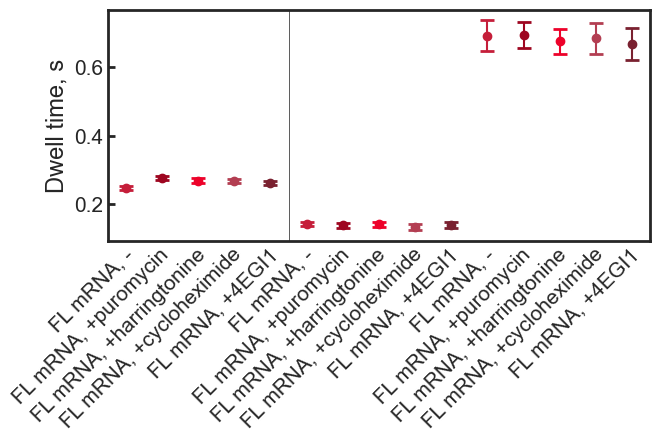

In [17]:
conditions_ordered = lst_title + lst_title + lst_title
colors = lst_color + lst_color + lst_color
lst_tau = []
lst_tau_se = []
for result in lst_results_single:
    lst_tau.append(result["tau"])
    lst_tau_se.append(result["tau_se"])
for result in lst_results_dual:
    lst_tau.append(result["tau1"])
    lst_tau_se.append(result["tau1_se"])
for result in lst_results_dual:
    lst_tau.append(result["tau2"])
    lst_tau_se.append(result["tau2_se"])

plt.figure(figsize=(7, 3))
x_pos = np.arange(len(conditions_ordered))
# line for eyes
plt.axvline((x_pos[4] + x_pos[5]) / 2, c="k", lw=0.5)
# plot
for i in range(len(conditions_ordered)):
    plt.errorbar(
        x_pos[i],
        lst_tau[i],
        yerr=lst_tau_se[i],
        fmt="o",
        capsize=5,
        capthick=2,
        color=colors[i],
    )
# other settings
plt.ylabel("Dwell time, s", fontsize=17)
plt.gca().spines[:].set_linewidth(2)
plt.gca().tick_params(
    axis="y",
    which="major",
    labelsize=15,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=2,
)
plt.gca().tick_params(
    axis="x",
    which="major",
    labelsize=15,
)
plt.xticks(
    x_pos + 0.3,
    conditions_ordered,
    rotation=45,
    ha="right",
    y=0.04,
)
plt.xlim(x_pos[0] - 0.5, x_pos[-1] + 0.5)
plt.savefig(
    "doterrorplot_tau.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)

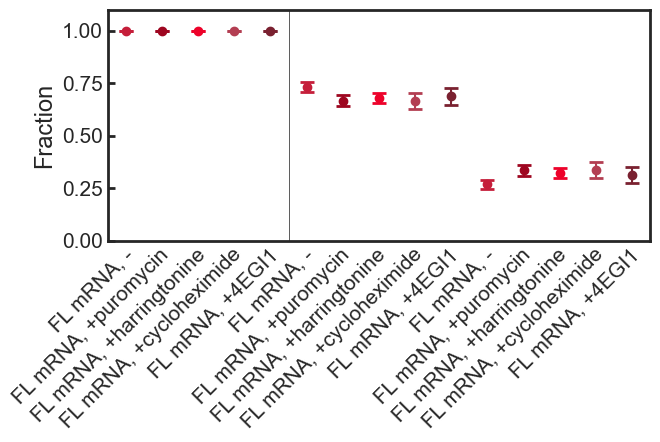

In [18]:
conditions_ordered = lst_title + lst_title + lst_title
colors = lst_color + lst_color + lst_color
lst_frac = []
lst_frac_se = []
for result in lst_results_single:
    lst_frac.append(1)
    lst_frac_se.append(0)
for result in lst_results_dual:
    lst_frac.append(result["a1"])
    lst_frac_se.append(result["a1_se"])
for result in lst_results_dual:
    lst_frac.append(result["a2"])
    lst_frac_se.append(result["a2_se"])

plt.figure(figsize=(7, 3))
x_pos = np.arange(len(conditions_ordered))
# line for eyes
plt.axvline((x_pos[4] + x_pos[5]) / 2, c="k", lw=0.5)
# plot
for i in range(len(conditions_ordered)):
    plt.errorbar(
        x_pos[i],
        lst_frac[i],
        yerr=lst_frac_se[i],
        fmt="o",
        capsize=5,
        capthick=2,
        color=colors[i],
    )
# other settings
plt.ylabel("Fraction", fontsize=17)
plt.gca().spines[:].set_linewidth(2)
plt.gca().tick_params(
    axis="y",
    which="major",
    labelsize=15,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=2,
)
plt.gca().tick_params(
    axis="x",
    which="major",
    labelsize=15,
)
plt.xticks(
    x_pos + 0.3,
    conditions_ordered,
    rotation=45,
    ha="right",
    y=0.04,
)
plt.xlim(x_pos[0] - 0.5, x_pos[-1] + 0.5)
plt.ylim(0, 1.1)
plt.savefig(
    "doterrorplot_frac.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)

# Interaction frequency

In [11]:
lst_N_dwell_per_track = [
    count_dwell_events(
        df["InCondensate"].to_numpy(),
        df["RNA_trackID"].to_numpy(),
    )
    for df in lst_df
]

In [12]:
def bootstrap_frac(arr):
    arr = arr[arr > 0] # first remove all tracks with no dwell events
    n = round(len(arr) * 0.3)
    f1_samples = []
    f2_samples = []
    f3_samples = []

    for _ in range(1000):
        bootstrap_sample = np.random.choice(arr, size=n, replace=True)
        f1 = np.sum(bootstrap_sample == 1) / n
        f2 = np.sum((bootstrap_sample > 1) & (bootstrap_sample <= 3)) / n
        f3 = np.sum(bootstrap_sample > 3) / n
        f1_samples.append(f1)
        f2_samples.append(f2)
        f3_samples.append(f3)

    f1_mean = np.mean(f1_samples)
    f1_sem = (np.percentile(f1_samples, 95) - np.percentile(f1_samples, 5)) / 2
    f2_mean = np.mean(f2_samples)
    f2_sem = (np.percentile(f2_samples, 95) - np.percentile(f2_samples, 5)) / 2
    f3_mean = np.mean(f3_samples)
    f3_sem = (np.percentile(f3_samples, 95) - np.percentile(f3_samples, 5)) / 2

    return f1_mean, f1_sem, f2_mean, f2_sem, f3_mean, f3_sem

In [13]:
lst_f1_mean = []
lst_f1_sem = []
lst_f2_mean = []
lst_f2_sem = []
lst_f3_mean = []
lst_f3_sem = []
lst_N = []

input_arrays = lst_N_dwell_per_track

for arr in input_arrays:
    f1_mean, f1_sem, f2_mean, f2_sem, f3_mean, f3_sem = bootstrap_frac(arr)
    lst_f1_mean.append(f1_mean)
    lst_f1_sem.append(f1_sem)
    lst_f2_mean.append(f2_mean)
    lst_f2_sem.append(f2_sem)
    lst_f3_mean.append(f3_mean)
    lst_f3_sem.append(f3_sem)
    lst_N.append(arr[arr > 0].shape[0])

df_fractions = pd.DataFrame(
    {
        "f1_mean": lst_f1_mean,
        "f1_sem": lst_f1_sem,
        "f2_mean": lst_f2_mean,
        "f2_sem": lst_f2_sem,
        "f3_mean": lst_f3_mean,
        "f3_sem": lst_f3_sem,
        "N_dwell_tracks": lst_N,
    },
    dtype=object,
)

In [14]:
df_fractions

,f1_mean,f1_sem,f2_mean,f2_sem,f3_mean,f3_sem,N_dwell_tracks
0,0.404151,0.015282,0.189906,0.012028,0.405943,0.015625,9708
1,0.435311,0.023919,0.193597,0.019802,0.371092,0.023482,3622
2,0.425538,0.022183,0.199582,0.01831,0.37488,0.020792,4734
3,0.420881,0.016496,0.197259,0.012867,0.38186,0.016295,8290
4,0.420677,0.020911,0.200854,0.017651,0.378469,0.021254,4627


f1_mean :
fraction: [40.415144230769236 43.53109475620975 42.55380281690141 42.0880981101729
 42.06772334293948]
SEM: [1.5281593406593408 2.391904323827049 2.2183098591549295
 1.6495778045838323 2.0911383285302563]

f2_mean :
fraction: [18.99055631868132 19.359705611775528 19.958169014084508 19.72585444310414
 20.08537463976945]
SEM: [1.2027815934065933 1.9802207911683523 1.8309859154929566
 1.286690792119019 1.7651296829971186]

f3_mean :
fraction: [40.59429945054946 37.109199632014715 37.488028169014086 38.18604744672295
 37.846902017291065]
SEM: [1.5625 2.348206071757128 2.0792253521126765 1.6294732609569762
 2.1253602305475487]



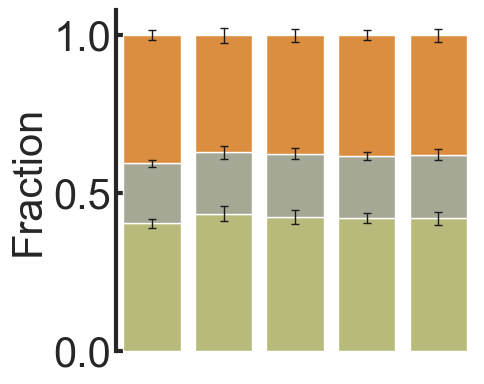

In [21]:
fig = plt.figure(figsize=(5, 4))
x = [1, 2, 3, 4, 5]
colors = [
    "#B8BA7B",
    "#A6A896",
    "#DB8D40",
]

bottom = np.zeros(len(x))
categories = [
    "f1_mean",  # N=1
    "f2_mean",  # 1<N<=3
    "f3_mean",  # 3<N
]
for i in range(len(categories)):
    plt.bar(
        x=x,
        height=df_fractions[categories[i]],
        yerr=df_fractions[categories[i][:-4] + "sem"],
        error_kw={"elinewidth": 1},
        capsize=3,
        bottom=bottom,
        color=colors[i],
    )
    print(categories[i], ":")
    print("fraction:", df_fractions[categories[i]].to_numpy() * 100)
    print("SEM:", df_fractions[categories[i][:-4] + "sem"].to_numpy() * 100)
    print()
    bottom += df_fractions[categories[i]]
plt.ylim(0, 1.08)
plt.ylabel("Fraction", size=30)
plt.xticks([])
plt.yticks([0, 0.5, 1])
plt.gca().spines[:].set_linewidth(3)
plt.gca().spines[["right", "top", "bottom"]].set_visible(False)
plt.gca().tick_params(
    axis="y",
    which="major",
    labelsize=30,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=3,
)
canvas_width = 0.5
plt.xlim(1 - canvas_width, 5 + canvas_width)
plt.xlabel("")
plt.tight_layout()
plt.savefig(
    "Fracs_N_dwell_events-split_by_1_3-2x_puro_har_chx_4egi1.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)

# lst_title = [
#     "FL mRNA, -",
#     "FL mRNA, +puromycin",
#     "FL mRNA, +harringtonine",
#     "FL mRNA, +cycloheximide",
#     "FL mRNA, +4EGI1",
# ]